Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


In [2]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

In [3]:
df = pd.read_csv('data/enhanced_train.csv')
df_test = pd.read_csv('data/enhanced_test.csv')

In [4]:
# Drop columns not needed for training
drop_cols = ['Unnamed: 0', 'Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier','Log_Sales']
X = df.drop(columns=drop_cols)
y = df['Log_Sales']  # Use log-transformed target


In [5]:

# Train-test split (stratified on Freq_Bin_Item_Cluster)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df['Freq_Bin_Item_Cluster']
)

In [6]:

# Sanity check: No missing profiles
train_profiles = set(df.loc[X_train.index, 'Item_Profile'])
val_profiles = set(df.loc[X_val.index, 'Item_Profile'])
missing_profiles = val_profiles - train_profiles
if missing_profiles:
    print(f"Warning: Some item profiles are only in validation: {missing_profiles}")

In [7]:

# One-hot encode categoricals
X_train_encoded = pd.get_dummies(X_train)
X_val_encoded = pd.get_dummies(X_val)

In [8]:
# Align columns for both sets
X_train_encoded, X_val_encoded = X_train_encoded.align(X_val_encoded, join='left', axis=1, fill_value=0)

# # Train XGBoost model
# model = XGBRegressor(
#     n_estimators=300,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     early_stopping_rounds=50,
# )

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,          # enough trees to capture complexity
    learning_rate=0.03,        # small step to generalize better
    max_depth=6,               # reasonable depth, avoids overfitting
    subsample=0.8,             # row sampling to reduce variance
    colsample_bytree=0.8,      # column sampling to reduce feature noise
    min_child_weight=3,        # control splits with small data
    gamma=0.1,                 # penalize unnecessary splits
    reg_alpha=0.5,             # L1 regularization (sparsity)
    reg_lambda=1.0,            # L2 regularization (stability)
    n_jobs=-1,
    random_state=42
)

model.fit(
    X_train_encoded, y_train,
    eval_set=[(X_val_encoded, y_val)],
    verbose=True
)

# 🔹 6. Evaluate model
y_val_pred_log = model.predict(X_val_encoded)
y_val_pred = np.expm1(y_val_pred_log)  # inverse of log1p
y_val_true = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
print(f"\nValidation RMSE (after inverse log transform): {rmse:.4f}")


[0]	validation_0-rmse:0.98198
[1]	validation_0-rmse:0.96061
[2]	validation_0-rmse:0.94035
[3]	validation_0-rmse:0.92080
[4]	validation_0-rmse:0.90196
[5]	validation_0-rmse:0.88393
[6]	validation_0-rmse:0.86843
[7]	validation_0-rmse:0.85173
[8]	validation_0-rmse:0.83556
[9]	validation_0-rmse:0.81997
[10]	validation_0-rmse:0.80499
[11]	validation_0-rmse:0.79071
[12]	validation_0-rmse:0.77706
[13]	validation_0-rmse:0.76492
[14]	validation_0-rmse:0.75367
[15]	validation_0-rmse:0.74162
[16]	validation_0-rmse:0.73024
[17]	validation_0-rmse:0.72025
[18]	validation_0-rmse:0.70968
[19]	validation_0-rmse:0.69977
[20]	validation_0-rmse:0.69060
[21]	validation_0-rmse:0.68168
[22]	validation_0-rmse:0.67309
[23]	validation_0-rmse:0.66490
[24]	validation_0-rmse:0.65758
[25]	validation_0-rmse:0.65011
[26]	validation_0-rmse:0.64272
[27]	validation_0-rmse:0.63624
[28]	validation_0-rmse:0.62978
[29]	validation_0-rmse:0.62355
[30]	validation_0-rmse:0.61806
[31]	validation_0-rmse:0.61237
[32]	validation_0-

In [9]:
X_test = pd.get_dummies(df_test.drop(columns=['Item_Identifier', 'Outlet_Identifier']))
X_test = X_test.reindex(columns=X_train_encoded.columns, fill_value=0)

test_preds_log = model.predict(X_test)
test_preds = np.expm1(test_preds_log)

# Save predictions
submission = df_test[['Item_Identifier', 'Outlet_Identifier']].copy()
submission['Item_Outlet_Sales'] = test_preds
submission.to_csv('xgb_1_submission.csv', index=False)


Feature Importance

In [10]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Sample some rows for speed
X_sample = X_val_encoded.sample(500, random_state=42)

# Create SHAP explainer from trained XGBoost model
explainer = shap.Explainer(model)

# Compute SHAP values
shap_values = explainer(X_sample)


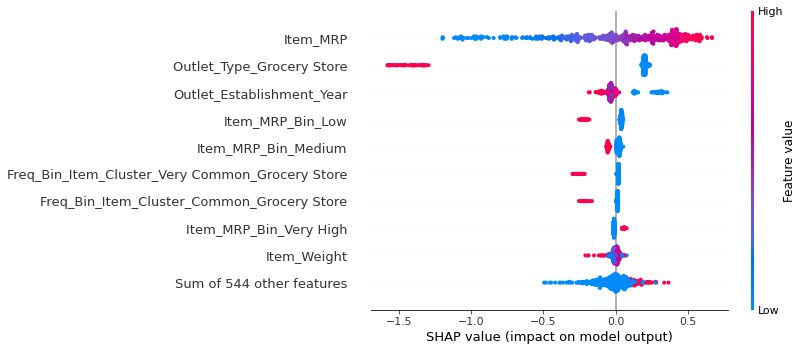

In [11]:
shap.plots.beeswarm(shap_values)


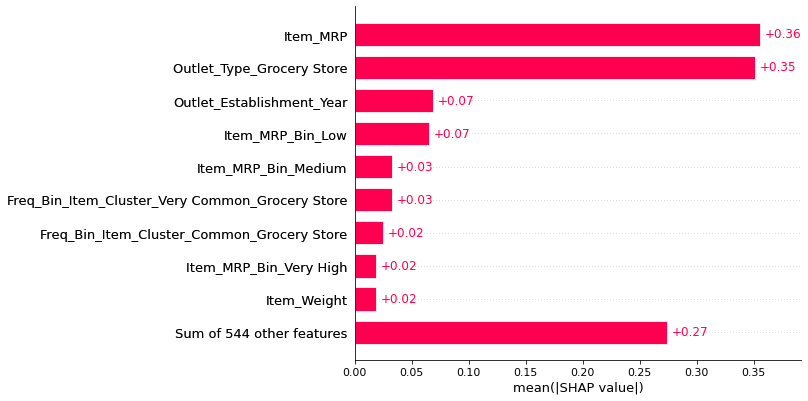

In [12]:
shap.plots.bar(shap_values)


In [13]:
# Calculate mean absolute SHAP values per feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame with feature names and their importance
shap_df = pd.DataFrame({
    'Feature': X_val_encoded.columns,
    'Mean_SHAP_Importance': shap_importance
})

# Sort by importance
shap_df = shap_df.sort_values(by='Mean_SHAP_Importance', ascending=False)

# Display top 20
print(shap_df.head(20))


                                               Feature  Mean_SHAP_Importance
2                                             Item_MRP              0.355133
32                           Outlet_Type_Grocery Store              0.351496
3                            Outlet_Establishment_Year              0.068326
224                                   Item_MRP_Bin_Low              0.065490
225                                Item_MRP_Bin_Medium              0.033006
545    Freq_Bin_Item_Cluster_Very Common_Grocery Store              0.032476
537         Freq_Bin_Item_Cluster_Common_Grocery Store              0.024431
226                             Item_MRP_Bin_Very High              0.018529
0                                          Item_Weight              0.018326
35                       Outlet_Type_Supermarket Type3              0.018312
1                                      Item_Visibility              0.015085
6                                           Outlet_Age              0.011332